### Fetch the image from the URL and save to npz file
- **Input**: data.csv (include url images)
- **Output**: list file npz (include image numpy array)

In [ ]:
import requests
from PIL import Image
import numpy as np
import pandas as pd
import os

In [ ]:
def fix_error_image(image_array):
    print("fix_error_image", image_array.shape)

    if image_array.shape == (320, 320, 4):
        return image_array[:, :, :3]
    else:
        return np.zeros((320, 320, 3), dtype=np.uint8)

In [ ]:
def url_to_numpy(url):
    try:
        # Fetch the image from the URL
        response = requests.get(url, stream=True)
    except:
        print("url failed")
        return np.zeros((320, 320, 3), dtype=np.uint8)

    # Open the image using PIL
    try:
        image = Image.open(response.raw)
    except:
        print("cannot identify image file")
        return np.zeros((320, 320, 3), dtype=np.uint8)

    # Convert the image to a NumPy array
    img_array = np.array(image, dtype=np.uint8)

    # Check shape
    if img_array.shape != (320, 320, 3):
        print("image_url_fail", url)
        img_array = fix_error_image(img_array)

    return img_array

In [ ]:
def save_file(index_file, merged_array):
    np.savez_compressed(f"/content/drive/MyDrive/shopee/images_array_{index_file}.npz", images_array=merged_array)
    print(f"Save file {index_file} successfully!")

In [ ]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/shopee/data.csv")

item_image = df['item_image']

print(item_image.shape)

(100000,)


In [ ]:
'''
range_split to split 500 images to 1 file .npz
Start with start_index_file = 0
If fail in index = 10, start_index_file = 10
'''

index_file = 1
range_split = 500
start_index_file = 200

for index, image_url in enumerate(item_image):
    # Init
    if index == 0:
        print("init image_url", image_url)
        merged_array = [url_to_numpy(image_url)]
        continue

    if index/range_split == index_file:
        print("index", index)
        print("index_file", index_file)

        # Increase index file
        print("increase index file")
        index_file += 1

        if index/range_split  < start_index_file - 1:
            continue

        # Save data before
        if index/range_split  >= start_index_file:
            save_file(index_file=index_file-1, merged_array=merged_array)

        # Reset init file
        print()
        print("reset init")
        merged_array = [url_to_numpy(image_url)]
        continue

    # Check condition start index
    if index/range_split  < start_index_file - 1:
        continue

    # Call the function to get the image as a NumPy array
    image_array = url_to_numpy(image_url)

    merged_array = np.concatenate((merged_array, [image_array]), axis=0)

    # Save last data
    if index == len(item_image) - 1:
        print("index", index)
        print("index_file", index_file)
        save_file(index_file=index_file, merged_array=merged_array)
        print("Done get all images!")

init image_url https://down-vn.img.susercontent.com/file/8e4dd848c8609665a8116d56fe44d6ec_tn
index 500
index_file 1
increase index file
index 1000
index_file 2
increase index file
index 1500
index_file 3
increase index file
index 2000
index_file 4
increase index file
index 2500
index_file 5
increase index file
index 3000
index_file 6
increase index file
index 3500
index_file 7
increase index file
index 4000
index_file 8
increase index file
index 4500
index_file 9
increase index file
index 5000
index_file 10
increase index file
index 5500
index_file 11
increase index file
index 6000
index_file 12
increase index file
index 6500
index_file 13
increase index file
index 7000
index_file 14
increase index file
index 7500
index_file 15
increase index file
index 8000
index_file 16
increase index file
index 8500
index_file 17
increase index file
index 9000
index_file 18
increase index file
index 9500
index_file 19
increase index file
index 10000
index_file 20
increase index file
index 10500
inde

Check file

(500, 320, 320, 3)
<class 'numpy.uint8'>


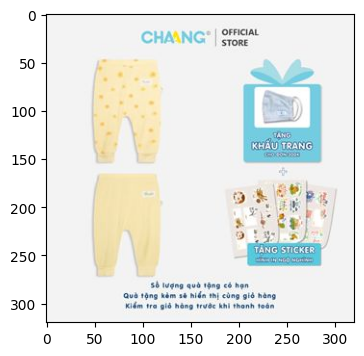

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/shopee/"

data = np.load(file_path + "images_array_200.npz", allow_pickle=True)

imgs_feature = data["images_array"]

print(imgs_feature.shape)

print(type(imgs_feature[0][0][0][0]))

plt.figure(figsize=(4,4))
plt.imshow(imgs_feature[0])

### Load image array and inference with model
- **Input**: list file npz (include image numpy array)
- **Output**: features file npz (include feature inference from model)

In [ ]:
import os
import numpy as np
import torch
import torchvision.models as models

file_path = "/content/drive/MyDrive/shopee/"
list_file_array = [name for name in os.listdir(file_path) if name.endswith((".npz"))]

print("Total file .npz:", len(list_file_array))
print("Sample file:", list_file_array[0])

if torch.cuda.is_available():
    print("Device: cuda")
else:
    print("Device: cpu")

Total file .npz: 200
Sample file: images_array_1.npz
Device: cuda


In [ ]:
# Create numpy array save features
image_features = None

for index_file in range(len(list_file_array)):
    file_name = f"images_array_{index_file+1}.npz"

    print("file_name:", file_name)

    # Load from npz file
    data = np.load(file_path + file_name, allow_pickle=True)

    # Get image array
    input_data = data["images_array"]

    # Convert to shape (B, C, H, W)
    input_data = input_data.transpose((0, 3, 1, 2))

    # Convert to a PyTorch tensor
    input_data = input_data.astype(np.float32) / 255.0
    input_data = torch.tensor(input_data, dtype=torch.float32)

    # Load the pre-trained model
    efficientnet_b3 = models.efficientnet_b3(weights='IMAGENET1K_V1')

    # Set the model to evaluation mode
    efficientnet_b3.eval()

    # Use a GPU (if available) for inference
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    efficientnet_b3 = efficientnet_b3.to(device)
    input_data = input_data.to(device)

    batch_size = 125
    num_samples = input_data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    # Log info
    if index_file == 0:
        print("batch_size", batch_size)
        print("num_samples", num_samples)
        print("num_batches", num_batches)

    # Inference loop
    with torch.no_grad():
        for i in range(num_batches):
            # Spit to batch
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch = input_data[start_idx:end_idx]

            # Forward pass through the model
            outputs = efficientnet_b3(batch)

            # Convert to numpy array
            outputs = outputs.detach().cpu().numpy()

            # Save features
            if index_file == 0 and i == 0:
                image_features = outputs
            else:
                image_features = np.concatenate((image_features, outputs), axis=0)

            print(image_features.shape)

image_features.shape
np.savez_compressed(f"{file_path}image_features/image_features.npz", image_features=image_features)
print(f"Save file image_features successfully!")

file_name: images_array_1.npz
batch_size 125
num_samples 500
num_batches 4
(125, 1000)
(250, 1000)
(375, 1000)
(500, 1000)
file_name: images_array_2.npz
(625, 1000)
(750, 1000)
(875, 1000)
(1000, 1000)
file_name: images_array_3.npz
(1125, 1000)
(1250, 1000)
(1375, 1000)
(1500, 1000)
file_name: images_array_4.npz
(1625, 1000)
(1750, 1000)
(1875, 1000)
(2000, 1000)
file_name: images_array_5.npz
(2125, 1000)
(2250, 1000)
(2375, 1000)
(2500, 1000)
file_name: images_array_6.npz
(2625, 1000)
(2750, 1000)
(2875, 1000)
(3000, 1000)
file_name: images_array_7.npz
(3125, 1000)
(3250, 1000)
(3375, 1000)
(3500, 1000)
file_name: images_array_8.npz
(3625, 1000)
(3750, 1000)
(3875, 1000)
(4000, 1000)
file_name: images_array_9.npz
(4125, 1000)
(4250, 1000)
(4375, 1000)
(4500, 1000)
file_name: images_array_10.npz
(4625, 1000)
(4750, 1000)
(4875, 1000)
(5000, 1000)
file_name: images_array_11.npz
(5125, 1000)
(5250, 1000)
(5375, 1000)
(5500, 1000)
file_name: images_array_12.npz
(5625, 1000)
(5750, 1000)
(

### Test search engine

Create Faiss index

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 32.6 MB/s eta 0:00:00


In [ ]:
import faiss
import numpy as np

file_path = "/content/drive/MyDrive/shopee/"
image_features_path = "image_features/image_features.npz"

image_features = np.load(f"{file_path}{image_features_path}", allow_pickle=True)

In [ ]:
image_features['image_features'].shape

(100000, 1000)

In [ ]:
dimension = 1000

index_faiss = faiss.IndexFlatL2(dimension)

# Add the image_features to the Faiss index
index_faiss.add(image_features["image_features"])

Update file test.jpg sample

(320, 320, 3)


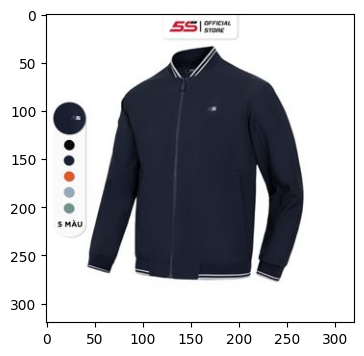

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("test.jpg")

image_query = np.array(image, dtype=np.float32) / 255.0

print(image_query.shape)

plt.figure(figsize=(4,4))
plt.imshow(image_query)

Inference

In [ ]:
import torch
import torchvision.models as models

# Load the pre-trained model
efficientnet_b3 = models.efficientnet_b3(weights='IMAGENET1K_V1')

# Set the model to evaluation mode
efficientnet_b3.eval()

# Use a GPU (if available) for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_b3 = efficientnet_b3.to(device)

image_query = image_query[np.newaxis,...]
image_query = image_query.transpose((0, 3, 1, 2))
print(image_query.shape)

# Convert to a PyTorch tensor
image_query = torch.tensor(image_query, dtype=torch.float32)
image_query = image_query.to(device)


# Forward pass through the model
with torch.no_grad():
    output = efficientnet_b3(image_query)

# print("output", output)
print("output", output.shape)

(1, 3, 320, 320)
output torch.Size([1, 1000])


In [ ]:
# Convert to numpy array
query_vector = output.detach().cpu().numpy()
print("query_vector", query_vector.shape)

query_vector (1, 1000)


Search

In [ ]:
k = 10
distances, indices = index_faiss.search(query_vector, k)

# Results
print("\nDistances to nearest neighbors:")
print(distances[0])

print("\nNearest neighbors:")
print("indices", indices)


Distances to nearest neighbors:
[1.0636925e-09 1.9026660e+02 1.9474541e+02 2.0266315e+02 2.1175455e+02
 2.1584424e+02 2.2993147e+02 2.3084512e+02 2.4190027e+02 2.4503253e+02]

Nearest neighbors:
indices [[38486 38574 38552 38628 38614 38627 38625 19600 38519 38547]]


In [ ]:
# Read the CSV file into a pandas DataFrame
import pandas as pd

df = pd.read_csv(file_path + "data.csv")

item_image = df["item_image"]
item_name = df["item_name"]

In [ ]:
for index in indices[0]:
    print(index)
    print("item_name", item_name[index])
    print("item_url", item_image[index])
    print()

38486
item_name Áo Khoác Bomber Nam 5S, Cản Gió, Chống Bám Bụi, Thiết Kế Basic Trẻ Trung, Lịch Lãm (AKB22001)
item_url https://down-vn.img.susercontent.com/file/sg-11134201-22120-wuwhiuqdnykv7e_tn

38574
item_name Áo Khoác Bomber Nam 5S, Công Nghệ Trượt Nước, Cản Gió, Thiết Kế Basic, Năng Động (03-AKB22001)
item_url https://down-vn.img.susercontent.com/file/sg-11134201-22120-6u9ivqtewwkv99_tn

38552
item_name Áo Khoác Bomber Nam 5S LÓT NỈ, Chống Bụi, Trượt Nước, Cực Ấm, Thiết Kế Trẻ Trung (AKB22003)
item_url https://down-vn.img.susercontent.com/file/sg-11134201-22120-4js51b4ccvkv70_tn

38628
item_name Áo Khoác Thể Thao Nam DELICATE 5S (5 Màu), Chất Poly Cao Cấp, Trượt Nước, Cản Gió, Thiết Kế Khỏe Khoắn (01-AKG22009)
item_url https://down-vn.img.susercontent.com/file/sg-11134201-22100-5joxom5angivc1_tn

38614
item_name Áo Bomber Nam 5S (5 màu) Premium, Công Nghệ BLOCKTECH, Trượt Nước, Cản Gió, Thiết Kế Basic, Năng Động (01-AKB22001)
item_url https://down-vn.img.susercontent.com/file/sg-

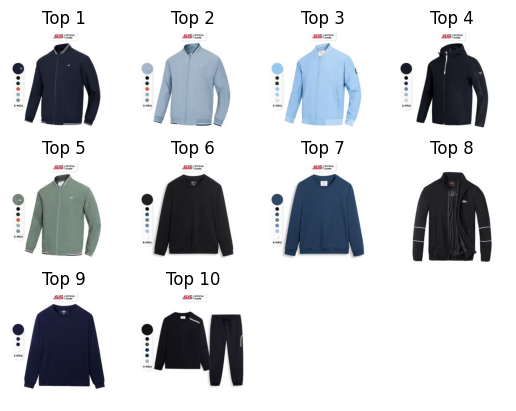

In [ ]:
import requests

def url_to_numpy(url):
    # Fetch the image from the URL
    response = requests.get(url, stream=True)

    # Open the image using PIL
    image = Image.open(response.raw)

    # Convert the image to a NumPy array
    img_array = np.array(image, dtype=np.uint8)

    return img_array

for i, index in enumerate(indices[0]):
    url = item_image[index]
    img_array = url_to_numpy(url)
    plt.subplot(3, 4, i+1)
    plt.title(f"Top {i+1}")
    plt.axis('off')
    plt.imshow(img_array)
plt.show()